--------------------------------------------------------------------------------------
# **CIFAR-10 Image Classification**
---------------------------------------------------------------------------------------

**Arash Shamseddini, PhD, MSc**

-------------------
## **Context**
-------------------

**CIFAR-10** (Canadian Institute For Advanced Research) is a collection of images with 10 different classes representing airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects.

Since the images in CIFAR-10 are low-resolution (32x32x3), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10.

---------------------
## **Objective**
---------------------

In this case study, I will build a number of multi-class classification algorithms to predict 10 different classes of the CIFAR-10 dataset using Convolutional Neural Networks and Transfer Learning.

-------------------
## **Dataset**
-------------------

The CIFAR-10 dataset consists of 60000 32x32x3, i.e., color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. You can learn more about this dataset here - https://www.cs.toronto.edu/~kriz/cifar.html

## **Loading libraries**

In [2]:
# Imports
import keras

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, LeakyReLU

from tensorflow.keras.optimizers import Adam

## **Importing and loading the CIFAR dataset**

The CIFAR dataset is already present in the Keras library in the form of an n-dimensional NumPy array. I will download this dataset from the Keras module here.

In [3]:
# Importing the dataset
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step


## **Preprocessing**

Now, I am going to prepare the CIFAR-10 dataset for training using TensorFlow’s `tf.data` pipeline. I split the data into training and validation sets, apply normalization, and add light data augmentation to improve generalization. I then convert everything into efficient batched datasets so the models can train faster and more smoothly.

## Normalization

In neural networks, it is always suggested to **normalize the feature inputs**. Normalization has the below benefits while training a neural network model:
1. Normalization makes the training faster and reduces the chances of getting stuck at local optima.
2. Also, weight decay and estimation can be done more conveniently with normalized inputs.
3. In deep neural networks, normalization helps to avoid exploding gradient problems. Gradient exploding problem occurs when large error gradients accumulate and result in very large updates to neural network model weights during training. This makes a model unstable and unable to learn from the training data.

## Data Augmentation

Data augmentation is used to artificially expand the training dataset by creating slightly modified versions of the original images. This has several benefits when training neural networks:

1. It helps the model generalize better by exposing it to natural variations such as flips, rotations, and zooming.

2. It reduces overfitting, because the model cannot memorize the training images as easily.

3. It makes the model more robust to real-world inputs, where lighting, orientation, and positioning can vary.

In [4]:

# Creating labels as a flat vector for tf.data
y_train_flat = y_train.reshape(-1,)
y_test_flat = y_test.reshape(-1,)

# Train/Validation split
from sklearn.model_selection import train_test_split
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(
    x_train, y_train_flat, test_size=0.1, random_state=42, shuffle=True
)

# Dataset shapes
print("Train:", x_train_split.shape)
print("Validation:", x_val_split.shape)
print("Test:", x_test.shape)

# Basic normalization function
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Data augmentation function
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

# Converting to tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train_split, y_train_split))
val_ds = tf.data.Dataset.from_tensor_slices((x_val_split, y_val_split))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_flat))

# Applying normalization + augmentation
train_ds = train_ds.map(normalize).map(augment).shuffle(5000).batch(64).prefetch(2)
val_ds   = val_ds.map(normalize).batch(64).prefetch(2)
test_ds  = test_ds.map(normalize).batch(64).prefetch(2)

print("TF Data pipeline created.")

Train: (45000, 32, 32, 3)
Validation: (5000, 32, 32, 3)
Test: (10000, 32, 32, 3)
TF Data pipeline created.


Here the data is stored in a **4-dimensional NumPy array**. The first dimension **45000** in the case of trainig set, is denoting **the number of images in the training data**, and each image is stacked on top of the other as a 3-dimensional NumPy array. The second dimension **32** is denoting **the number of pixels along the x-axis**, the third dimension **32** is denoting **the number of pixels along the y-axis**, and the fourth dimension **3** is **the total number of channels in those images**, i.e., these are colored images consisting of RGB (Red, Green, and Blue) channels.

Below is the 3-dimensional NumPy representation of the first image in the training data. Each pixel in the image has 3 values - the intensity of R, G, and B channels, and the size of each image is 32x32. So, each image is represented by 32 arrays of shape 32x3.

array([[[ 18,  12,  24],
        [ 22,  16,  28],
        [ 27,  21,  33],
        ...,
        [ 26,  19,  30],
        [ 14,  11,  18],
        [ 11,  10,  16]],

       [[ 18,  12,  24],
        [ 21,  15,  27],
        [ 25,  19,  31],
        ...,
        [ 27,  23,  32],
        [ 21,  21,  27],
        [ 17,  18,  24]],

       [[ 23,  17,  29],
        [ 22,  16,  28],
        [ 20,  14,  26],
        ...,
        [ 29,  28,  37],
        [ 25,  26,  32],
        [ 21,  25,  30]],

       ...,

       [[ 44,  24,  35],
        [ 48,  26,  38],
        [ 55,  31,  43],
        ...,
        [130, 131, 159],
        [105, 104, 127],
        [ 65,  60,  82]],

       [[ 25,  17,  27],
        [ 29,  21,  31],
        [ 38,  28,  38],
        ...,
        [125, 127, 155],
        [ 91,  89, 113],
        [ 49,  42,  64]],

       [[ 16,  13,  20],
        [ 19,  16,  24],
        [ 22,  18,  27],
        ...,
        [101, 100, 125],
        [ 55,  51,  72],
        [ 26,  19,  37]]], dtype=uint8)
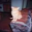

In [20]:
# Chekcing the 1st instance in the training set
x_train_split[0]

The target labels are encoded in numerical format. Here, encoding 3 denotes the category **cat**. Later, I will create a list of category names to convert the number to its original category name and use this for visualization.

In [5]:
# Checking the target label for the 1st instance in training set
print(y_train_split[0])

3


## **Converting NumPy arrays to images and visualizing some random images**

As seen above, all the images are stored as NumPy arrays, and values in the array denote the pixel intensities of the image. Let's use matplotlib's **imshow** function to visualize the image from NumPy arrays. Below I am plotting a few random images from the dataset, to see what the images look like.

In [6]:
# Declaring the number of classes
num_classes = 10

# Creating a list of category names in alphabetical order
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

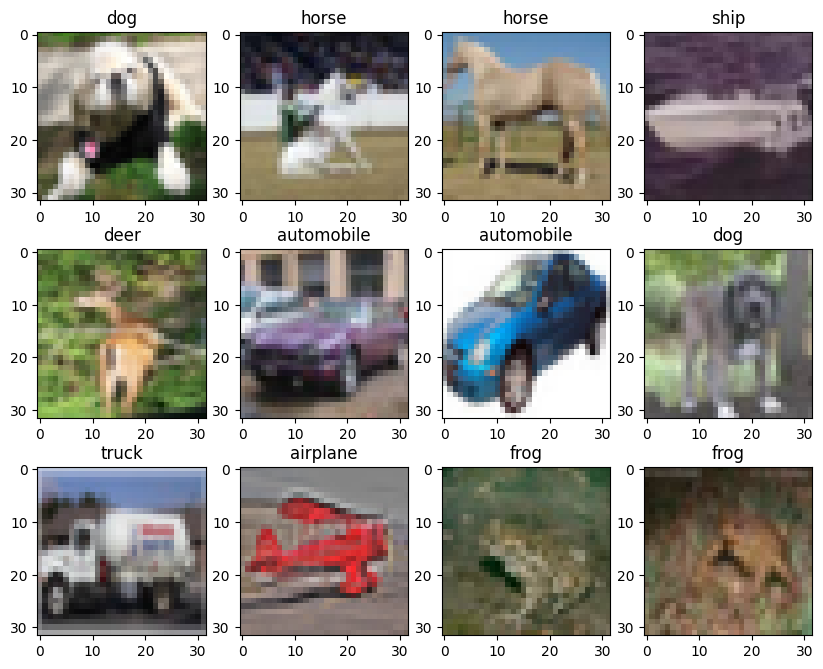

In [7]:
# Display the plot
plt.show()

# Declaring the number of rows
rows = 3

# Declaring the number of columns
cols = 4

fig = plt.figure(figsize = (10, 8))

for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train_split))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(x_train_split[random_index])
        ax.set_title(cifar10_classes[y_train_split[random_index]])

plt.show()

## **Model building**

Let's now create a few CNN models sequentially where we will be adding the layers one after another.

## Model 1

The first model I am going to build is a simple CNN with a few convolution and pooling layers.

First, let's **set the seed for random number generators in NumPy, Python, and TensorFlow** to be able to reproduce the same results every timethe code is run.

In [8]:
# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In this section, I will build my first baseline convolutional neural network (CNN). This model includes a couple of convolutional layers for feature extraction, followed by max pooling to reduce spatial dimensions. After flattening the feature maps, I add a dense layer to learn higher-level patterns, and finally a softmax output layer for predicting the 10 image classes. This first model gives me a simple starting point to evaluate performance before experimenting with deeper architectures and additional regularization.

In [9]:
# Initialized a sequential model
model_1 = Sequential()

# Adding the first convolutional layer with 16 filters and the kernel size of 3x3, and 'same' padding

# The input_shape denotes input dimension of CIFAR images
model_1.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", input_shape = (32, 32, 3)))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_1.add(LeakyReLU(0.1))

# Adding the second convolutional layer with 32 filters and the kernel size of 3x3
model_1.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_1.add(LeakyReLU(0.1))

# Adding max pooling to reduce the size of the output of second convolutional layer
model_1.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the 3-d output of the convolutional layer after max pooling to make it ready for creating dense connections
model_1.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
model_1.add(Dense(256))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_1.add(LeakyReLU(0.1))

# Adding the output layer with 10 neurons and 'softmax' activation function (for a multi-class classification problem)
model_1.add(Dense(10, activation = 'softmax'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Printing the model summary
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,105,066 (8.03 MB)

 Trainable params: 2,105,066 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

As seen in the model summary, this CNN model will train and learn **2,105,066** parameters (weights and biases).

Let's now compile and train the model using the train data. Here, we are using the loss function - **sparse_categorical_crossentropy** as this is a multi-class classification problem. I will try to minimize this loss at every iteration using the **adam** optimizer of my choice. Also, I am choosing **accuracy** as the metric to measure the performance of the model.

In [11]:
# Compiling the 1st model
model_1.compile(
    optimizer=tf.keras.optimizers.Adamax(learning_rate=0.005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Let's now train the model for **10** epoch, which is a full pass through of the training set, using cross validation on the validation set.

In [12]:
# Training 1st model with cross validation
history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=2
)

Epoch 1/15
704/704 - 55s - 78ms/step - accuracy: 0.4485 - loss: 1.5415 - val_accuracy: 0.5310 - val_loss: 1.3286
Epoch 2/15
704/704 - 43s - 61ms/step - accuracy: 0.5679 - loss: 1.2106 - val_accuracy: 0.5812 - val_loss: 1.1818
Epoch 3/15
704/704 - 44s - 63ms/step - accuracy: 0.6219 - loss: 1.0755 - val_accuracy: 0.6400 - val_loss: 1.0266
Epoch 4/15
704/704 - 43s - 62ms/step - accuracy: 0.6534 - loss: 0.9870 - val_accuracy: 0.6556 - val_loss: 1.0107
Epoch 5/15
704/704 - 82s - 116ms/step - accuracy: 0.6731 - loss: 0.9270 - val_accuracy: 0.6276 - val_loss: 1.1492
Epoch 6/15
704/704 - 46s - 65ms/step - accuracy: 0.6932 - loss: 0.8751 - val_accuracy: 0.6834 - val_loss: 0.9382
Epoch 7/15
704/704 - 45s - 64ms/step - accuracy: 0.7120 - loss: 0.8270 - val_accuracy: 0.6794 - val_loss: 1.0256
Epoch 8/15
704/704 - 44s - 63ms/step - accuracy: 0.7244 - loss: 0.7914 - val_accuracy: 0.6976 - val_loss: 0.9300
Epoch 9/15
704/704 - 44s - 63ms/step - accuracy: 0.7326 - loss: 0.7636 - val_accuracy: 0.6888 -

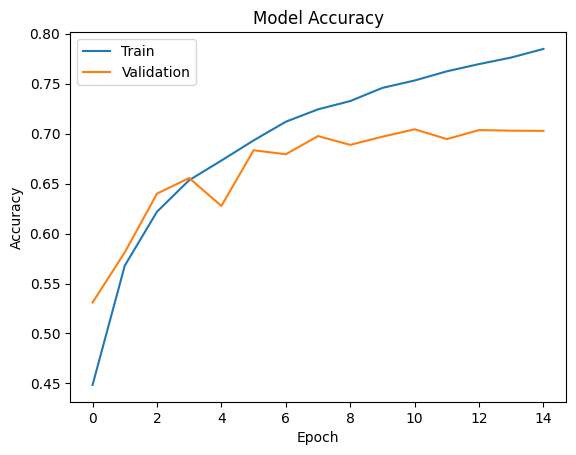

In [13]:
# Plotting accuracy vs epoch
plt.plot(history_1.history['accuracy'])

plt.plot(history_1.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc = 'upper left')

# Display the plot
plt.show()

In [14]:
# Evaluating the model on test data
test_loss, test_acc = model_1.evaluate(test_ds)
print("Test accuracy for model 1:", round(test_acc, 3))


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7133 - loss: 0.9661
Test accuracy for model 1: 0.709


**Observations:**

From the accuracy curves, I can see that this first model is learning steadily and improving on both the training and validation sets. The validation accuracy follows the training accuracy closely, which indicates that the model is not severely overfitting at this stage. The final test accuracy of around **71%** is reasonable for a simple baseline CNN on CIFAR-10 and gives me a good reference point before I experiment with deeper architectures and regularization techniques.

## Model 2

Let's try adding a few dropout layers to the model structure to reduce overfitting and see if this improves the model or not.

First, it is necessary to clear the previous model's history from the session.

Also, let's fix the seed again after clearing the backend.

In [15]:
# Clearing the backend
from tensorflow.keras import backend

backend.clear_session()

In [16]:
# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [17]:
# Initialized a sequential model
model_2 = Sequential()

# Adding the first convolutional layer with 16 filters and the kernel size of 3x3, and 'same' padding

# The input_shape denotes the input dimension of CIFAR images
model_2.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", input_shape = (32, 32, 3)))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_2.add(LeakyReLU(0.1))

# Adding dropout to randomly switch off 20% neurons to reduce overfitting
model_2.add(Dropout(0.2))

# Adding the second convolutional layer with 32 filters and the kernel size of 3x3
model_2.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_2.add(LeakyReLU(0.1))

# Adding dropout to randomly switch off 20% neurons to reduce overfitting
model_2.add(Dropout(0.2))

# Adding max pooling to reduce the size of output of second convolutional layer
model_2.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the 3-d output of the convolutional layer after max pooling to make it ready for creating dense connections
model_2.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
model_2.add(Dense(256))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_2.add(LeakyReLU(0.1))

# Adding dropout to randomly switch off 50% neurons to reduce overfitting
model_2.add(Dropout(0.5))

# Adding the output layer with 10 neurons and 'softmax'  activation function since this is a multi-class classification problem
model_2.add(Dense(10, activation = 'softmax'))

In [18]:
# Printing the model summary
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,105,066 (8.03 MB)

 Trainable params: 2,105,066 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compiling the 2nd model
model_2.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.005),
    metrics=['accuracy']
)

In [20]:
# # Training 2nd model with cross validation
history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=2
)

Epoch 1/15
704/704 - 52s - 74ms/step - accuracy: 0.4152 - loss: 1.6304 - val_accuracy: 0.4846 - val_loss: 1.4880
Epoch 2/15
704/704 - 46s - 65ms/step - accuracy: 0.5159 - loss: 1.3543 - val_accuracy: 0.5546 - val_loss: 1.3600
Epoch 3/15
704/704 - 83s - 118ms/step - accuracy: 0.5555 - loss: 1.2503 - val_accuracy: 0.5608 - val_loss: 1.3555
Epoch 4/15
704/704 - 45s - 63ms/step - accuracy: 0.5760 - loss: 1.1888 - val_accuracy: 0.6008 - val_loss: 1.1790
Epoch 5/15
704/704 - 44s - 62ms/step - accuracy: 0.5960 - loss: 1.1448 - val_accuracy: 0.6024 - val_loss: 1.2233
Epoch 6/15
704/704 - 84s - 119ms/step - accuracy: 0.6100 - loss: 1.1036 - val_accuracy: 0.6290 - val_loss: 1.1461
Epoch 7/15
704/704 - 44s - 62ms/step - accuracy: 0.6184 - loss: 1.0753 - val_accuracy: 0.6506 - val_loss: 1.0893
Epoch 8/15
704/704 - 45s - 63ms/step - accuracy: 0.6276 - loss: 1.0540 - val_accuracy: 0.6632 - val_loss: 1.0205
Epoch 9/15
704/704 - 45s - 64ms/step - accuracy: 0.6380 - loss: 1.0279 - val_accuracy: 0.6438 

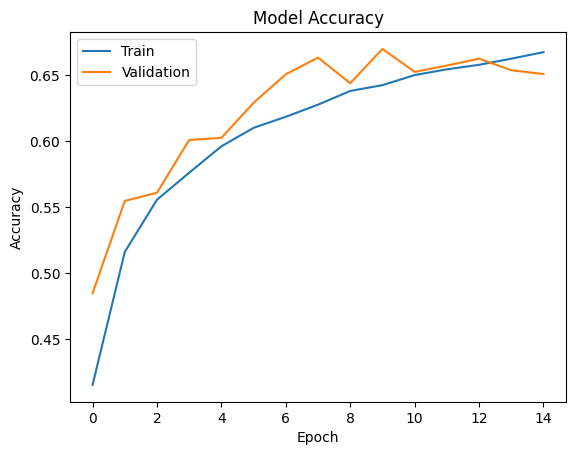

In [21]:
# Plotting accuracy vs epochs
plt.plot(history_2.history['accuracy'])

plt.plot(history_2.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc = 'upper left')

# Display the plot
plt.show()

In [22]:
# Evaluating the model on test data
test_loss, test_acc = model_2.evaluate(test_ds)
print("Test accuracy for model 2:", round(test_acc, 3))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6411 - loss: 1.1443
Test accuracy for model 2: 0.645


**Observations:**

For this second model, I introduced dropout layers to reduce overfitting. While the training and validation curves follow each other fairly closely, the overall accuracy remains lower than in the first model. The model appears more regularized, but it also seems to underfit slightly, which is reflected in the lower test accuracy of about **65%**. This gives me a good indication that simply adding dropout is not enough, and that I may need a deeper architecture or more expressive features in the next iteration.

## Model 3

Let's now build another model with a few more convolution layers, max-pooling layers, and dropout layers to reduce overfitting. Also, let's change the learning rate and the number of epochs and see if the model's performance improves.

In [23]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

In [24]:
# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

In [25]:
# Initialized a sequential model
model_3 = Sequential()

# Adding the first convolutional layer with 16 filters and the kernel size of 3x3, and 'same' padding

# The input_shape denotes input dimension of CIFAR images
model_3.add(Conv2D(filters = 16, kernel_size = (3, 3), padding = "same", input_shape = (32, 32, 3)))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Adding the second convolutional layer with 32 filters and the kernel size of 3x3
model_3.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Adding max pooling to reduce the size of output of the second convolutional layer
model_3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding dropout to randomly switch off 25% of the network to reduce overfitting
model_3.add(Dropout(0.25))

# Adding the third convolutional layer with 32 filters and the kernel size of 3x3
model_3.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Adding the fourth convolutional layer with 64 filters and the kernel size of 3x3
model_3.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))

# Adding LeakyRelu activation function with a negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Adding max pooling to reduce the size of output of the fourth convolutional layer
model_3.add(MaxPooling2D(pool_size = (2, 2)))

# Adding dropout to randomly switch off 25% of the network to reduce overfitting
model_3.add(Dropout(0.25))

# Flattening the 3-d output of the convolutional layer after max pooling to make it ready for creating dense connections
model_3.add(Flatten())

# Adding a fully connected dense layer with 256 neurons
model_3.add(Dense(256))

# Adding LeakyRelu activation function with negative slope of 0.1
model_3.add(LeakyReLU(0.1))

# Adding dropout to randomly switch off 50% of dense layer neurons to reduce overfitting
model_3.add(Dropout(0.5))

# Adding the output layer with 10 neurons and 'softmax' activation function since this is a multi-class classification problem
model_3.add(Dense(10, activation = 'softmax'))

In [26]:
# Summary of the model
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,084,234 (4.14 MB)

 Trainable params: 1,084,234 (4.14 MB)

 Non-trainable params: 0 (0.00 B)

In this new architecture, although the number of convolutional layers has increased, but the total number of trainable parameters has reduced significantly (~ 50%). This is due to the addition of a few max-pooling layers in between. Let's train this model and this time for a little more epochs.

In [27]:
# Compiling the 3rd model
model_3.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [28]:
# Training the 3rd model
history_3 = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=2
)

Epoch 1/15
704/704 - 56s - 80ms/step - accuracy: 0.3729 - loss: 1.7256 - val_accuracy: 0.4770 - val_loss: 1.4567
Epoch 2/15
704/704 - 46s - 65ms/step - accuracy: 0.4841 - loss: 1.4338 - val_accuracy: 0.5382 - val_loss: 1.2846
Epoch 3/15
704/704 - 46s - 65ms/step - accuracy: 0.5248 - loss: 1.3253 - val_accuracy: 0.5516 - val_loss: 1.2344
Epoch 4/15
704/704 - 45s - 63ms/step - accuracy: 0.5555 - loss: 1.2457 - val_accuracy: 0.5810 - val_loss: 1.1656
Epoch 5/15
704/704 - 47s - 67ms/step - accuracy: 0.5839 - loss: 1.1746 - val_accuracy: 0.6308 - val_loss: 1.0554
Epoch 6/15
704/704 - 46s - 65ms/step - accuracy: 0.6055 - loss: 1.1171 - val_accuracy: 0.6288 - val_loss: 1.0257
Epoch 7/15
704/704 - 46s - 65ms/step - accuracy: 0.6184 - loss: 1.0782 - val_accuracy: 0.6226 - val_loss: 1.0472
Epoch 8/15
704/704 - 45s - 64ms/step - accuracy: 0.6340 - loss: 1.0409 - val_accuracy: 0.6386 - val_loss: 1.0293
Epoch 9/15
704/704 - 46s - 66ms/step - accuracy: 0.6456 - loss: 1.0085 - val_accuracy: 0.6616 - 

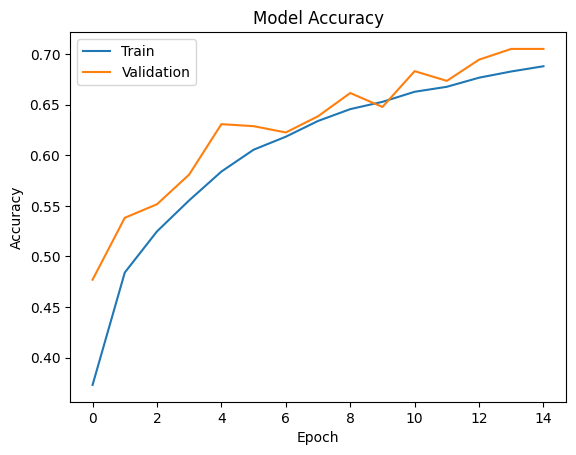

In [29]:
plt.plot(history_3.history['accuracy'])

plt.plot(history_3.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc = 'upper left')

# Display the plot
plt.show()

In [30]:
# Evaluating the model on test data
test_loss, test_acc = model_3.evaluate(test_ds)
print("Test accuracy for model 3:", round(test_acc, 3))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7019 - loss: 0.8519
Test accuracy for model 3: 0.701


**Observations:**

This third model is deeper and includes additional convolutional layers along with dropout for regularization. From the accuracy curves, I can see that both the training and validation performance improve more steadily compared to the first two models. The gap between the two curves is small, which suggests that the model is generalizing better without severe overfitting. The validation accuracy consistently stays above the training accuracy across most epochs, and the final test accuracy of about **70%** confirms that this architecture is stronger and more balanced than Models 1 and 2.

I can try out some more iterations and tune some of the hyperparameters to further improve the model but hyperparameter tuning is exhaustive and can take a long time to find the right set of values for each hyperparameter.

Let's try some other techniques like **Transfer Learning** to see if I can speed up the process of training the model and can also get a more accurate model overall.

## Model 4: Transfer Learning

**Transfer learning** is a popular deep learning technique that **reuses a pre-trained model on a new problem**. **It can train deep neural networks with comparatively little data.** This is very useful in the data science field since most real-world problems typically do not have millions of labeled data points to train complex models.

Let's begin by clearing the backend and fixing the seed.

In [32]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

In [33]:
# Fixing the seed for random number generators
np.random.seed(42)

import random

random.seed(42)

tf.random.set_seed(42)

I will use VGG16 as the pre-trained model. More on this model can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16).

Also, wIe will use the **Functional Model API** to build the model this time because it allows explicitly connecting the output of one layer to the input of another layer. Each connection is specified. More can be found [here](https://www.tensorflow.org/guide/keras/functional).

In [34]:
# Importing necessary libraries
from tensorflow.keras import Model

from tensorflow.keras.applications.vgg16 import VGG16

Now, let's instantiate the VGG16 model.

- The **VGG16** model was originally trained on images of size **224 x 224**. The TensorFlow application allows the minimum image size of **32x32** which is luckily the same as the image size in the CIFAR-10 dataset.


- By specifying the argument **include_top=False argument**, I can load a network that doesn't include the classification layers at the top, i.e., we will use the VGG16 model only for feature extraction.

In [35]:
# Initializing VGG16 model instance
vgg_model = VGG16(weights = 'imagenet',
                       include_top = False,
                       input_shape = (32, 32, 3), pooling = 'max')

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [36]:
# Checking summary of the model
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

- The VGG16 model has more than **14.7 M** trainable parameters.
- Here, I will not train any of the layers from the VGG16 model, i.e., I will use the pre-trained weights and biases.
- Also, I can take any layer's output from the VGG16 model as the input of our new model. Here, I will take the output of the **3rd** block of the VGG16 model as the input of my new model.

In [37]:
# Getting layers up to 3rd block
transfer_layer = vgg_model.get_layer('block3_pool')
# Freezing the retained layers
vgg_model.trainable = False

Now, I will add classification layers to my model using Functional Model API.

In [38]:
# Adding classification layers on top of it
x = Flatten()(transfer_layer.output)

x = Dense(256, activation = 'relu')(x)

x = Dense(128, activation = 'relu')(x)

x = Dropout(0.3)(x)

x = Dense(64, activation = 'relu')(x)

x = BatchNormalization()(x)

pred = Dense(10, activation = 'softmax')(x)

# Initializing the model
model_4 = Model(vgg_model.input, pred)

In [40]:
# Compiling the 4th model
model_4.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.0005),
              metrics = ['accuracy'])

In [42]:
# Fitting the 4th model
history_4 = model_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    verbose=2
)

Epoch 1/15
704/704 - 58s - 83ms/step - accuracy: 0.4496 - loss: 1.5822 - val_accuracy: 0.6420 - val_loss: 1.0420
Epoch 2/15
704/704 - 54s - 76ms/step - accuracy: 0.6066 - loss: 1.1315 - val_accuracy: 0.6956 - val_loss: 0.8764
Epoch 3/15
704/704 - 49s - 69ms/step - accuracy: 0.6498 - loss: 1.0075 - val_accuracy: 0.7154 - val_loss: 0.8273
Epoch 4/15
704/704 - 58s - 82ms/step - accuracy: 0.6771 - loss: 0.9370 - val_accuracy: 0.7402 - val_loss: 0.7658
Epoch 5/15
704/704 - 49s - 70ms/step - accuracy: 0.6971 - loss: 0.8762 - val_accuracy: 0.7572 - val_loss: 0.7099
Epoch 6/15
704/704 - 62s - 88ms/step - accuracy: 0.7102 - loss: 0.8387 - val_accuracy: 0.7536 - val_loss: 0.7280
Epoch 7/15
704/704 - 57s - 81ms/step - accuracy: 0.7205 - loss: 0.8083 - val_accuracy: 0.7570 - val_loss: 0.6979
Epoch 8/15
704/704 - 53s - 75ms/step - accuracy: 0.7272 - loss: 0.7871 - val_accuracy: 0.7572 - val_loss: 0.7500
Epoch 9/15
704/704 - 50s - 71ms/step - accuracy: 0.7350 - loss: 0.7676 - val_accuracy: 0.7646 - 

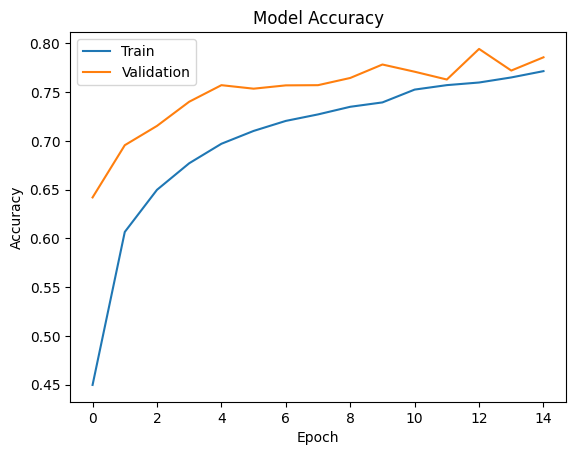

In [43]:
# Plotting accuracy vs epoch
plt.plot(history_4.history['accuracy'])

plt.plot(history_4.history['val_accuracy'])

plt.title('Model Accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.legend(['Train', 'Validation'], loc = 'upper left')

# Display the plot
plt.show()

In [44]:
# Evaluating the model on test data
test_loss, test_acc = model_4.evaluate(test_ds)
print("Test accuracy for model 4:", round(test_acc, 3))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7848 - loss: 0.6505
Test accuracy for model 4: 0.785


**Observations:**

In this final model, in whcih I applied transfer learning using **VGG16** as the feature extractor. Compared to the previous models, the performance improves noticeably, and the validation accuracy stabilizes at a much higher level. The gap between the training and validation curves stays relatively small, which suggests that the pre-trained convolutional layers provide strong, generalizable features even with limited training. The model achieves a test accuracy of about **79%**, which is the best among all models so far and demonstrates the benefit of leveraging pre-trained networks for image classification tasks like CIFAR-10.

## **Making predictions**

Before moving on to making predictions, let's take a look at the accuracy of all the models together.

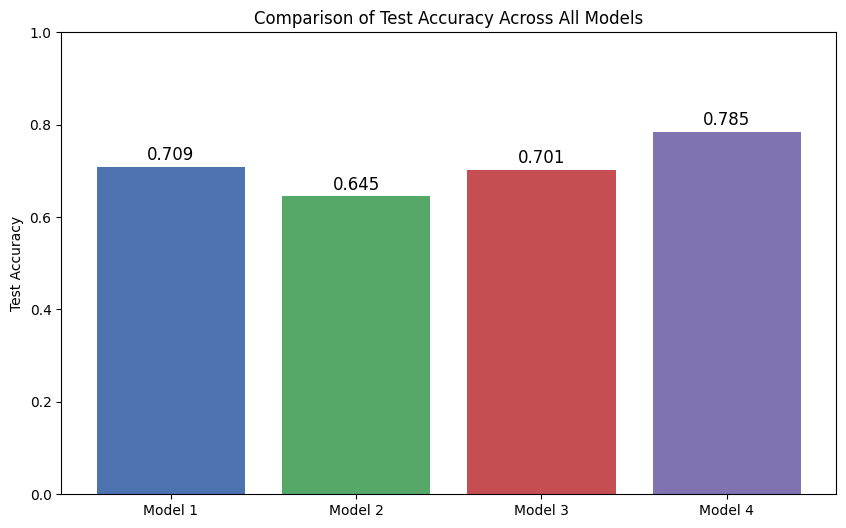

In [45]:
# Evaluating each model on the test dataset
_, acc_model_1 = model_1.evaluate(test_ds, verbose=0)
_, acc_model_2 = model_2.evaluate(test_ds, verbose=0)
_, acc_model_3 = model_3.evaluate(test_ds, verbose=0)
_, acc_model_4 = model_4.evaluate(test_ds, verbose=0)

# Prepareing plot data
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4']
test_accuracies = [acc_model_1, acc_model_2, acc_model_3, acc_model_4]

# Creating bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, test_accuracies, color=['#4c72b0', '#55a868', '#c44e52', '#8172b2'])

# Annotating bars with values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords='offset points',
                 ha='center', fontsize=12)

# Labels and title
plt.ylabel('Test Accuracy')
plt.title('Comparison of Test Accuracy Across All Models')
plt.ylim(0, 1.0)

plt.show()


Based on above plot, what I am going to do is to use **all** four trained models to generate predictions on the test dataset. Instead of relying on a single model, I combine their probability outputs using simple soft voting. This means I average the predicted class probabilities from each model and then choose the class with the highest combined probability. This approach gives me a more stable and robust prediction by leveraging the strengths of all four models.

In [46]:
# Making predictions on the test data using all four models
pred1 = model_1.predict(test_ds)
pred2 = model_2.predict(test_ds)
pred3 = model_3.predict(test_ds)
pred4 = model_4.predict(test_ds)

# Simple soft voting: averaging probability distributions
final_proba = (pred1 + pred2 + pred3 + pred4) / 4.0

# Converting probabilities to predicted class labels
final_pred_classes = np.argmax(final_proba, axis=1)

# Calculating the probability of the predicted class
final_pred_max_probas = np.max(final_proba, axis=1)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


Classification Report for Ensemble Model:

              precision    recall  f1-score   support

    airplane       0.80      0.83      0.82      1000
  automobile       0.84      0.91      0.88      1000
        bird       0.75      0.67      0.70      1000
         cat       0.77      0.40      0.53      1000
        deer       0.72      0.73      0.73      1000
         dog       0.76      0.60      0.67      1000
        frog       0.59      0.95      0.73      1000
       horse       0.83      0.83      0.83      1000
        ship       0.90      0.83      0.87      1000
       truck       0.80      0.88      0.84      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.76     10000
weighted avg       0.78      0.77      0.76     10000



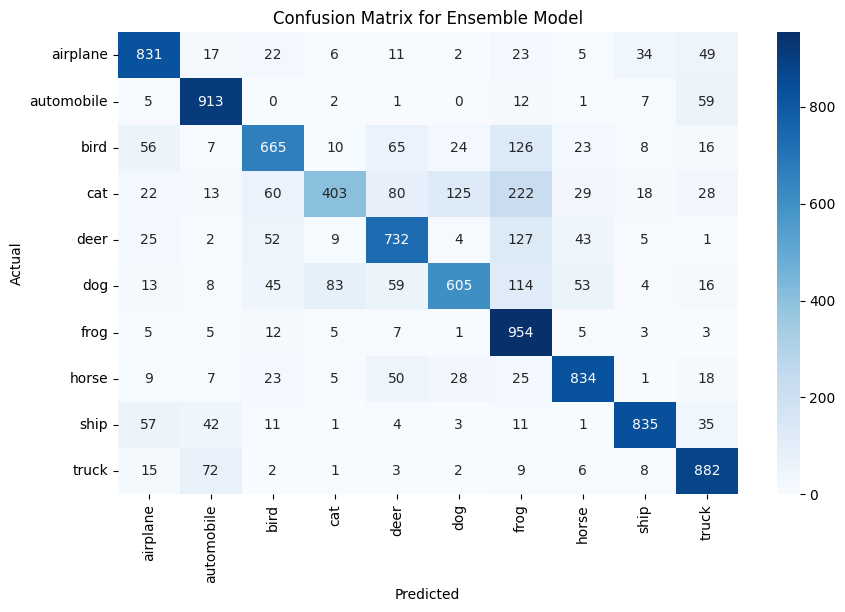

In [47]:

from sklearn.metrics import classification_report, confusion_matrix

# Ensemble true and predicted labels
y_true = y_test_flat                     # true labels (1D integer array)
y_pred = final_pred_classes              # ensemble predictions

# Printing the classification report
print("Classification Report for Ensemble Model:\n")
print(classification_report(y_true, y_pred, target_names=cifar10_classes))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=cifar10_classes,
            yticklabels=cifar10_classes,
            cmap="Blues")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Ensemble Model')
plt.show()


**Observations:**

- The ensemble model achieves around **77%** accuracy on the test set, which is consistent with the validation performance and indicates that the final model generalizes well. The class-level recall varies considerably across the dataset, showing that the ensemble is able to identify some categories very reliably, such as “frog,” “ship,” and “truck,” but still struggles with classes that are visually more ambiguous, such as “cat” and “dog.”

- From the confusion matrix, I can see that misclassifications are concentrated among animal classes, especially between “cat,” “dog,” “deer,” and “horse.” These categories share similar textures and shapes, which explains why the model finds them challenging. On the other hand, classes with more distinct visual features—like “automobile,” “ship,” and “truck”—achieve high precision and recall, meaning the ensemble can recognize them with confidence.

- Overall, combining the four models through soft voting provides a balanced and robust classifier, but the variability in recall highlights opportunities to further improve performance, especially for fine-grained distinctions among animal classes.

## **Visualizing the predicted images**

Let's now what the ensemble models predict for some random images from the test set.

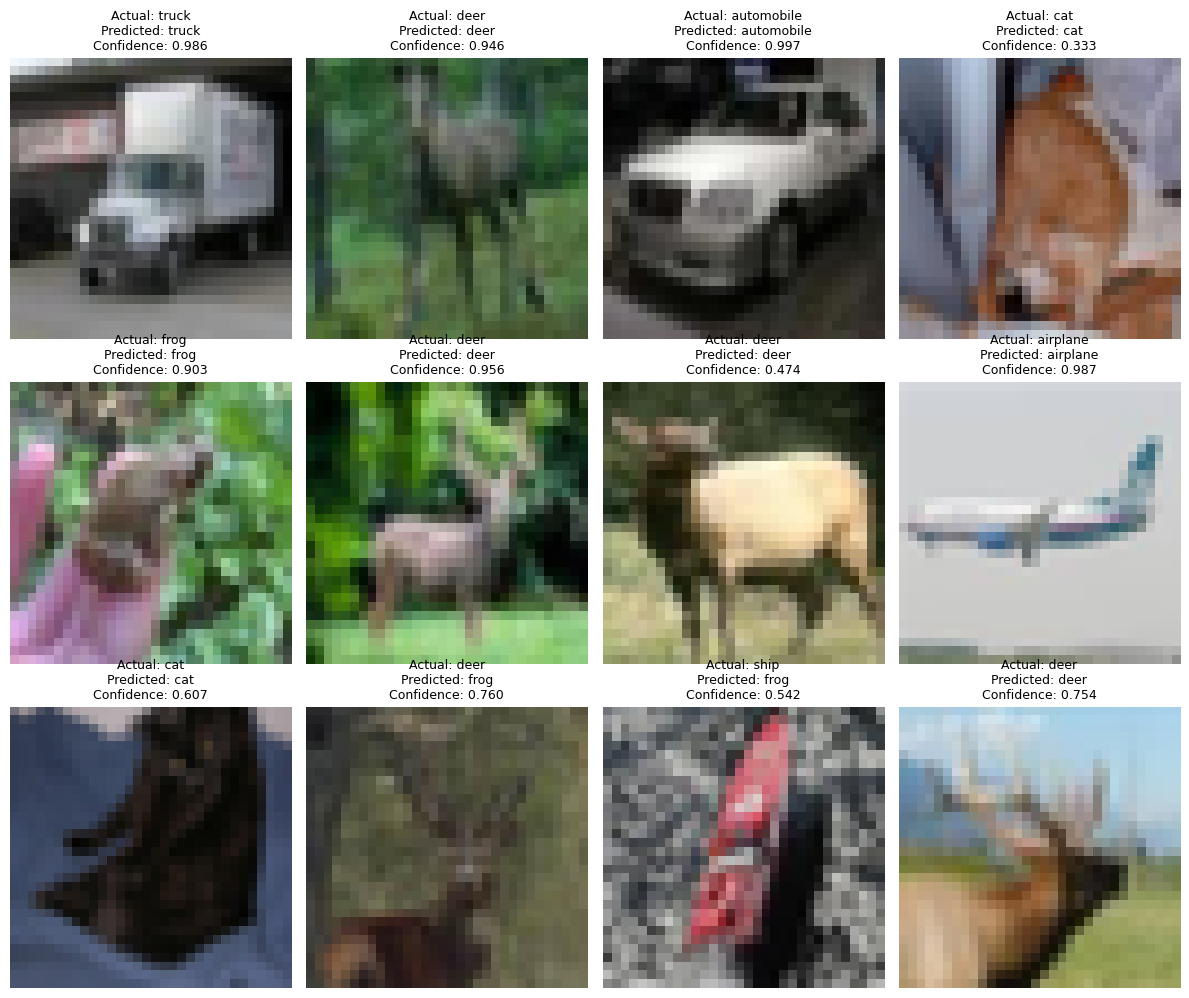

In [48]:
rows = 3
cols = 4

fig = plt.figure(figsize=(12, 10))

for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test_flat))

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.imshow(x_test[random_index])

        # Ensemble predictions
        pred_label = cifar10_classes[final_pred_classes[random_index]]
        pred_proba = final_pred_max_probas[random_index]

        # True label
        true_label = cifar10_classes[y_test_flat[random_index]]

        ax.set_title(
            f"Actual: {true_label}\nPredicted: {pred_label}\nConfidence: {pred_proba:.3f}",
            fontsize=9
        )
        ax.axis("off")

plt.tight_layout()
plt.show()


## **Saving the models for later use**

In [49]:
# Creating a models directory
import os
os.makedirs("models", exist_ok=True)

# Save all four models
model_1.save("models/model_1.h5")
model_2.save("models/model_2.h5")
model_3.save("models/model_3.h5")
model_4.save("models/model_4.h5")


## **Conclusion**

In this notebook, I implemented and compared four different deep learning models for the CIFAR-10 image classification task, ranging from simple CNN architectures to a transfer learning model using VGG16. Along the way, I prepared an efficient input pipeline using tf.data, applied normalization and augmentation strategies, and evaluated each model on a held-out test set to understand how architectural depth, regularization, and pre-trained features influence performance.

After training all models, I combined their probability outputs using a simple soft-voting ensemble. This ensemble approach produced more stable and robust predictions by leveraging the strengths of all four architectures. The results show clear performance gains from deeper networks and transfer learning, and the ensemble achieved the strongest overall accuracy.

There are still several opportunities to improve this work, such as experimenting with more advanced architectures (e.g., ResNet or EfficientNet), tuning hyperparameters, or extending the ensemble with alternative weighting strategies. However, the models developed here provide a solid foundation and a clear demonstration of how different convolutional designs and ensemble methods can be used to tackle a multi-class image classification problem.

## **The End**